In [1]:
from pathlib import Path
from thermophysicalProperties import Database
import matplotlib.pyplot as plt
import numpy as np
from frozendict import frozendict
import pint
ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
from uncertainties import ufloat
import os
from numdifftools import Derivative
from scipy.optimize import minimize
import warnings
import sys
import thermoToolsAdditions as tta
from thermoToolsAdditions import convert_to_thermochem_name
from paths import THERMOCHIMICA, THERMOCHIMICA_CHLORIDE_DATA, MSTDB_TP_DATA, MSTDB_TP_RK_DATA, SALT_OPTIMIZATION

warnings.filterwarnings("ignore")

import thermoToolsAdditions as tta
from thermoToolsAdditions import convert_to_thermochem_name

# File IO input parameters for thermoToolsAdditions
tta.Config.set_config(
    thermochimica_path = THERMOCHIMICA,
    output_path = SALT_OPTIMIZATION / 'thermophysicalProperties',
    data_file = THERMOCHIMICA_CHLORIDE_DATA
)

db = Database(MSTDB_TP_DATA, MSTDB_TP_RK_DATA)

# Fuel Optimization

For the fuel salt, a chloride salt was chosen, and has been identified as a good choice for fast systems by a number of reactor designers (e.g. Terra Power) due to its relatively high $A$ (minimal moderation) and various fissile components and fission products tend to have high solubilities in chloride melts, making them good fuel carriers. The base components under consideration are
1. $\text{KCl}$
2. $\text{NaCl}$
3. $\text{ZrCl}_4$
4. $\text{AlCl}$
5. $\text{UCl}_3$ (the most common redox state of U in chloride melts)
6. $\text{PuCl}_3$ (also the most common redox state)
7. $\text{NdCl}_3$ (only used as a surrogate for Cm)

A notable exclusion is $\text{MgCl}_2$, which is often considered due to its ability to control redox or lower the melting point of the salt, which can be a concern for chlorides which generally have higher melting points than fluorides although $\text{RbCl}$ can also be used for this purpose, however, no thermophysical properties are currently available in MSTDB-TP, so it has been excluded. Additionally, it was determined that Zr additives would be used for redox control, so Mg is not necesssary. $\text{PuCl}$ and $\text{UCl}$ are both present in the salt, however we will consider their ratio fixed (these components are more relevant for neutronics than thermal hydraulics) and also the fraction of actinides in the fuel salt is also constrained by criticality and fuel cycle requirements. We will perform this calculation with a fixed actinide fraction with the hope that they're soluble at the periphery of the fuel tube, and we will verify this after the fact.

For the fuel salt, the heating requirements are also a concern, and we would like the salt to not have a prohibitively high melting point, but in this design, the fuel salt will actually reach very high temperatures on the centerline, and the boiling temperature of the fuel salt becomes a relevant consideration. To acheive a high power density in the salt (comparable to a LWR at ~100 kW/L) a boiling point of around 1800 K is desirable, based on rudimentary thermohydraulics scoping calculations.

Availability of thermophysical properties
| Pure Compound   | $\rho$ | $\mu$ | $k$  | $c_p$ |
| --------------- | ------ | ----- | ---- | ----- | 
| $\text{KCl}$    |   ✓    |   ✓   |  ✓   |   ✓   |
| $\text{NaCl}$   |   ✓    |   ✓   |  ✓   |   ✓   |
| $\text{ZrCl}_4$ |   ✓    |   ✓   |  ✗   |   ✗   |
| $\text{AlCl}$   |   ✓    |   ✓   |  ✗   |   ✓   |
| $\text{UCl}_3$  |   ✓    |   ✗   |  ✗   |   ✗   |
| $\text{PuCl}_3$ |   ✗    |   ✗   |  ✗   |   ✓   |
| $\text{NdCl}_3$ |   ✓    |   ✓   |  ✗   |   ✓   |

Which is admittedly quite sparse, but is more than sufficient to fully calculate all of the thermophysical properties of a salt of interest (so long as we don't exclude some endmembers).

## Optimization Methodology
An important consideration in the fuel sallt is the centerline temperature. In our design, since molten salt is a relatively poor conductor, the centerline can reach _very_ high temperatures, and the constraint then becomes the fuel salt melting point. The temperature profile (assuming pure conduction) is parabolic, and the centerline temperature is given by
$$
    T(0) = \frac{\dot{q}r_o^2}{4k} + T_\infty + \frac{\dot{q}r_o}{2h}\nonumber
$$
Where $T(0)$ is the centerline temperature, $\dot{q}$ is the volumetric heat generation rate within the rod (our target is around 100 kW/L), $r_o$ is the outer fuel rod radius, $k$ is the fuel salt thermal conductivity, $h$ is the heat transfer coefficient from the outer rod surface to the coolant salt (which is not affected by the fuel salt), and $T_\infty$ is the bulk coolant temperature away from the thermal boundary layer near the rod surface. From this expression, it's clear that increasing the thermal conductivity of the fuel salt and/or raising its boiling point will loosen the constraints on our design. However, we also want our fuel salt to melt at a reasonable temperature (say 800-900 K). So our goal will be to maximize the thermal conductivity while keeping the melting point below 800-900 K, and the boiling point above 2000 K.

## Actinide Composition
The fuel composition is (representing an actinide fraction of 55 mole %): $\text{PuCl}_3$ - $\text{NdCl}_3$ - $\text{UCl}_3$ ($39.8$ - $0.2$ - $15.0$ mole %) which is notably _mostly_ $\text{PuCl}_3$, the rest of the fuel salt (45 mole %) is unconstrained. 

In [4]:
T_max = 780 # Maximum melting point
T_min = 2000 # Minimum boiling point

actinide_composition = np.array([0.398, 0.002, 0.15])

def check_melting_and_boiling(x, endmembers, elements_used):
    x = np.append(x, 0.45-sum(x))
    x = np.append(x, actinide_composition)

    # Convert from NaF to Na F (unfortunate mismatch in convention)
    new_endmembers = [convert_to_thermochem_name(endmember) for endmember in endmembers]
    salt = dict({endmember: x[i] for i, endmember in enumerate(new_endmembers)})

    try:
        T_m, T_b = tta.calculate_melting_and_boiling(salt, elements_used, suppress_output=True, phase_tolerance=0.9)
        return min(T_max - T_m, T_b - T_min)
    except:
        # Return a large negative value to indicate that the constriaint was not satisfied
        return -1E+06 # The supplied salt does not have a melting or boiling point in the given range (it could be that the salt sublimates)
    
# A constraint function which ensures that sum(x) = 1
def constraint(x):
    return 0.45 - np.sum(x)

# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint})

In [5]:
T_f = 1/2*(T_min+T_max) # Assumed average fuel temperature in K

# Define the objective function
def objective(x, endmembers):
    x = np.append(x, 0.45-sum(x))
    x = np.append(x, actinide_composition)
    salt = frozendict({endmember: x[i] for i, endmember in enumerate(endmembers)})
    try:
        k = db.get_tp('thermal_conductivity', salt)(T_f).nominal_value
    except OverflowError:
        return 1E+03
    objective = k
    if np.isnan(objective) or np.isinf(objective):
        return 1E+03
    else:
        return -objective
    
endmembers = ['NaCl', 'KCl', 'AlCl3', 'ZrCl4', 'PuCl3', 'NdCl3', 'UCl3']
elements_used = ['Cl', 'Na', 'K', 'Al', 'Zr', 'Pu', 'Nd', 'U']

In [6]:
# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint}, \
        {'type': 'ineq', 'fun': check_melting_and_boiling, 'args': (endmembers, elements_used)})

guess = [0.25, 0.14, 0.01] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 1), (0.001, 1)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={
        'verbose': 3, 
        'gtol': 1e-3, 
        'xtol': 1e-3, 
        'maxiter': 200,
        'initial_constr_penalty': 200.0,
        'initial_tr_radius': 1.0,
        'initial_barrier_tolerance': 0.1
    },
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   4   |   0   | -4.1438e-01 | 1.00e+00 | 9.02e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   0   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x7088f2023960 in ???
#1  0x7088f2022ac5 in ???
#2  0x7088f1c4251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x61e920702555 in ???
#4  0x61e9206f7a97 in ???
#5  0x61e920761356 in ???
#6  0x61e9207643ef in ???
#7  0x61e9207467d3 in ???
#8  0x61e9206f3537 in ???
#9  0x61e9207520f9 in ???
#10  0x61e9206e9fdb in ???
#11  0x61e9206e7b97 in ???
#12  0x61e9206e63c8 in ???
#13  0x7088f1c29d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x7088f1c29e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x61e9206e63f4 in ???
#16  0xffffffffffffffff in ???

Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x750963c23960 in ???
#1  0x750963c22ac5 in ???
#2  0x75096384251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_s

|   2   |   8   |   1   | -4.1438e-01 | 1.00e-01 | 9.02e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   4   |
|   3   |  12   |   4   | -4.1438e-01 | 5.61e-01 | 9.01e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |
|   4   |  16   |   7   | -4.1438e-01 | 3.15e+00 | 8.91e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |
|   5   |  20   |  10   | -4.1438e-01 | 3.55e+00 | 8.69e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |
|   6   |  24   |  13   | -4.1438e-01 | 3.68e+00 | 8.25e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |
|   7   |  28   |  16   | -4.1438e-01 | 3.94e+00 | 7.40e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |
|   8   |  32   |  19   | -4.1438e-01 | 4.28e+00 | 6.07e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x745815023960 in ???
#1  0x745815022ac5 in ???
#2  0x745814c4251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x57ff677d2555 in ???
#4  0x57ff677c7a97 in ???
#5  0x57ff67831356 in ???
#6  0x57ff678343ef in ???
#7  0x57ff677c2b99 in ???
#8  0x57ff677c3206 in ???
#9  0x57ff678220f9 in ???
#10  0x57ff677b9fdb in ???
#11  0x57ff677b7b97 in ???
#12  0x57ff677b63c8 in ???
#13  0x745814c29d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x745814c29e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x57ff677b63f4 in ???
#16  0xffffffffffffffff in ???


|   9   |  36   |  22   | -4.1438e-01 | 4.75e+00 | 3.99e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   1   |
|  10   |  40   |  24   | -4.1438e-01 | 4.75e+00 | 2.09e-02 | 2.81e+01 | 2.00e+02 |  1.00e-01   |   4   |
|  11   |  44   |  27   | -4.1535e-01 | 4.75e+00 | 1.94e-02 | 2.81e+01 | 1.48e+13 |  1.00e-01   |   1   |
|  12   |  48   |  28   | -4.1535e-01 | 4.75e+00 | 1.94e-02 | 2.81e+01 | 1.48e+13 |  1.00e-01   |   4   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x752aa0423960 in ???
#1  0x752aa0422ac5 in ???
#2  0x752aa004251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x5abeb2296555 in ???
#4  0x5abeb228ba97 in ???
#5  0x5abeb22f5356 in ???
#6  0x5abeb22f83ef in ???
#7  0x5abeb22da7d3 in ???
#8  0x5abeb2287537 in ???
#9  0x5abeb22e60f9 in ???
#10  0x5abeb227dfdb in ???
#11  0x5abeb227bb97 in ???
#12  0x5abeb227a3c8 in ???
#13  0x752aa0029d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x752aa0029e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x5abeb227a3f4 in ???
#16  0xffffffffffffffff in ???


|  13   |  52   |  31   | -4.1535e-01 | 4.75e-01 | 1.94e-02 | 2.81e+01 | 1.48e+13 |  1.00e-01   |   1   |
|  14   |  56   |  34   | -4.1192e-01 | 3.33e+00 | 1.57e-02 | 2.83e+00 | 1.07e+15 |  1.00e-01   |   2   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x7126a8823960 in ???
#1  0x7126a8822ac5 in ???
#2  0x7126a844251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x616d91a24555 in ???
#4  0x616d91a19a97 in ???
#5  0x616d91a83356 in ???
#6  0x616d91a863ef in ???
#7  0x616d91a14b99 in ???
#8  0x616d91a15206 in ???
#9  0x616d91a740f9 in ???
#10  0x616d91a0bfdb in ???
#11  0x616d91a09b97 in ???
#12  0x616d91a083c8 in ???
#13  0x7126a8429d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x7126a8429e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x616d91a083f4 in ???
#16  0xffffffffffffffff in ???


|  15   |  60   |  37   | -4.1024e-01 | 4.47e+00 | 1.64e-02 | 2.83e+00 | 1.07e+15 |  1.00e-01   |   1   |
|  16   |  64   |  40   | -4.1024e-01 | 4.47e+00 | 9.77e-03 | 2.83e+00 | 1.07e+15 |  1.00e-01   |   1   |
|  17   |  68   |  43   | -4.1024e-01 | 4.47e-01 | 9.77e-03 | 2.83e+00 | 1.07e+15 |  1.00e-01   |   1   |
|  18   |  72   |  46   | -4.1024e-01 | 4.47e-02 | 9.77e-03 | 2.83e+00 | 1.07e+15 |  1.00e-01   |   1   |
|  19   |  76   |  47   | -4.1024e-01 | 4.47e-03 | 9.77e-03 | 2.83e+00 | 1.07e+15 |  1.00e-01   |   2   |
|  20   |  80   |  48   | -4.1013e-01 | 3.13e-02 | 9.71e-03 | 2.83e+00 | 6.09e+27 |  1.00e-01   |   2   |
|  21   |  84   |  49   | -4.0962e-01 | 2.19e-01 | 9.46e-03 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   2   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x71dd01e23960 in ???
#1  0x71dd01e22ac5 in ???
#2  0x71dd01a4251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x5d901a8a8555 in ???
#4  0x5d901a89da97 in ???
#5  0x5d901a907356 in ???
#6  0x5d901a90a3ef in ???
#7  0x5d901a898b99 in ???
#8  0x5d901a899206 in ???
#9  0x5d901a8f80f9 in ???
#10  0x5d901a88ffdb in ???
#11  0x5d901a88db97 in ???
#12  0x5d901a88c3c8 in ???
#13  0x71dd01a29d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x71dd01a29e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x5d901a88c3f4 in ???
#16  0xffffffffffffffff in ???


|  22   |  88   |  52   | -4.1288e-01 | 1.34e+00 | 6.53e-03 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   1   |
|  23   |  92   |  53   | -4.1288e-01 | 1.34e-01 | 6.53e-03 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   4   |
|  24   |  96   |  54   | -4.1288e-01 | 1.34e-02 | 6.53e-03 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   4   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x701fb6a23960 in ???
#1  0x701fb6a22ac5 in ???
#2  0x701fb664251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x5f40229a8555 in ???
#4  0x5f402299da97 in ???
#5  0x5f4022a07356 in ???
#6  0x5f4022a0a3ef in ???
#7  0x5f40229ec7d3 in ???
#8  0x5f4022999537 in ???
#9  0x5f40229f80f9 in ???
#10  0x5f402298ffdb in ???
#11  0x5f402298db97 in ???
#12  0x5f402298c3c8 in ???
#13  0x701fb6629d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x701fb6629e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x5f402298c3f4 in ???
#16  0xffffffffffffffff in ???


|  25   |  100  |  55   | -4.1299e-01 | 1.34e-02 | 1.02e-02 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   4   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x70223f623960 in ???
#1  0x70223f622ac5 in ???
#2  0x70223f24251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x6513dc09f555 in ???
#4  0x6513dc094a97 in ???
#5  0x6513dc0fe356 in ???
#6  0x6513dc1013ef in ???
#7  0x6513dc08fb99 in ???
#8  0x6513dc090206 in ???
#9  0x6513dc0ef0f9 in ???
#10  0x6513dc086fdb in ???
#11  0x6513dc084b97 in ???
#12  0x6513dc0833c8 in ???
#13  0x70223f229d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x70223f229e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x6513dc0833f4 in ???
#16  0xffffffffffffffff in ???


|  26   |  104  |  56   | -4.1311e-01 | 1.34e-02 | 1.01e-02 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   4   |
|  27   |  108  |  57   | -4.1322e-01 | 1.34e-02 | 7.99e-03 | 2.83e+00 | 1.43e+28 |  1.00e-01   |   4   |
|  28   |  112  |  58   | -4.1238e-01 | 9.37e-02 | 7.94e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  29   |  116  |  60   | -4.1238e-01 | 9.37e-03 | 7.94e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |



Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x7341a3a23960 in ???
#1  0x7341a3a22ac5 in ???
#2  0x7341a364251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x5af8e2071555 in ???
#4  0x5af8e2066a97 in ???
#5  0x5af8e20d0356 in ???
#6  0x5af8e20d33ef in ???
#7  0x5af8e20b57d3 in ???
#8  0x5af8e2062537 in ???
#9  0x5af8e20c10f9 in ???
#10  0x5af8e2058fdb in ???
#11  0x5af8e2056b97 in ???
#12  0x5af8e20553c8 in ???
#13  0x7341a3629d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x7341a3629e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x5af8e20553f4 in ???
#16  0xffffffffffffffff in ???


|  30   |  120  |  61   | -4.1278e-01 | 6.56e-02 | 9.94e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  31   |  124  |  62   | -4.1342e-01 | 6.56e-02 | 7.26e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   4   |
|  32   |  128  |  63   | -4.1342e-01 | 6.56e-03 | 7.26e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  33   |  132  |  64   | -4.1327e-01 | 4.59e-02 | 7.23e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  34   |  136  |  65   | -4.1327e-01 | 4.59e-03 | 7.23e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  35   |  140  |  66   | -4.1337e-01 | 3.21e-02 | 7.17e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  36   |  144  |  67   | -4.1393e-01 | 2.25e-01 | 6.75e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  37   |  148  |  68   | -4.1393e-01 | 2.25e-02 | 6.75e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  38   |  152  |  69   | -4.1422e-01 | 1.57e-01 | 6.47e-03 | 2.83e+00 | 7.50e+28 |  1.00e-01   |   2   |
|  39   |  156  |  70   | -4.1422e-01 | 1.57e-

In [7]:
result

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -0.41426248772524044
                 x: [ 2.517e-01  1.415e-01  3.914e-02]
               nit: 98
              nfev: 392
              njev: 98
              nhev: 0
          cg_niter: 140
      cg_stop_cond: 2
              grad: [-1.209e-01  2.150e-01  0.000e+00]
   lagrangian_grad: [-7.797e-03  7.658e-03  8.752e-05]
            constr: [array([ 1.761e-02]), array([-2.828e+00]), array([ 2.517e-01,  1.415e-01,  3.914e-02])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00]]), array([[ 0.000e+00,  0.000e+00,  0.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00],
                           [ 0.000e+00,  0.000e+00,  1.000e+00]])]
       constr_nfev: [392, 392, 0]
       constr_njev: [0, 0, 0]
       constr_nhev: [0, 0, 0]
                 v: [array([-1.009e-02]), array([-1.

So the optimum is $\text{NaCl}$ - $\text{KCl}$ - $\text{AlCl}_3$ - $\text{ZrCl}_4$ - $\text{PuCl}_3$ - $\text{NdCl}_3$ - $\text{UCl}_3$ ( $25.2$ - $14.1$ - $3.9$ - $2.0$ - $39.8$ - $0.2$ - $15.0$ mole %)

In [8]:
test_composition = {'Na Cl': 0.25, 'K Cl': 0.141, 'Zr Cl_4': 0.04, 'Pu Cl_3': 0.398, 'Nd Cl_3': 0.002, 'U Cl_3': 0.15}
tta.calculate_melting_and_boiling(test_composition, elements_used, ntstep=150)

Thermochimica calculation initiated.


Thermochimica calculation finished.


(788.5906040268457, 2164.4295302013425)

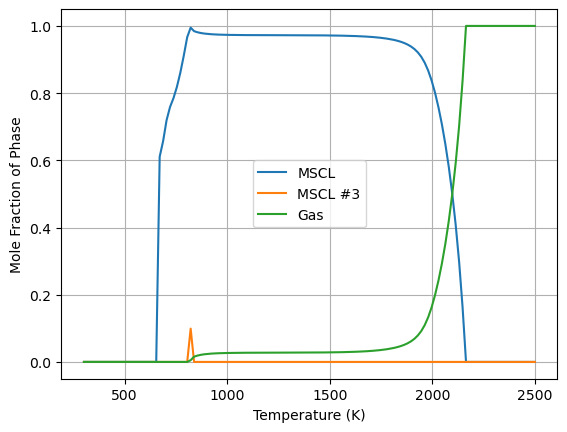

In [10]:
output = tta.thermoOut(default=True)
temperatures = output.temperatures.values()
mole_fraction_liquid = output.get_phase_fraction('MSCL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSCL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, np.array(mole_fraction_liquid) + np.array(mole_fraction_liquid_3), label='MSCL')
plt.plot(temperatures, mole_fraction_liquid_3, label='MSCL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()